In [3]:
!apt-get update -y
!apt-get install -y ocl-icd-opencl-dev pocl-opencl-icd clinfo g++ make
!clinfo | head -n 80

Get:1 https://cli.github.com/packages stable InRelease [3,917 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:4 https://cli.github.com/packages stable/main amd64 Packages [345 B]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,297 kB]
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,867 kB]
Hit:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:13 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu

In [4]:
!nvidia-smi

Wed Jan 14 15:06:39 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   61C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# **Задача 1**

In [5]:
%%writefile kernel.cl
__kernel void vec_add(__global const float* A,
                      __global const float* B,
                      __global float* C,
                      const int N)
{
    int gid = get_global_id(0);
    if (gid < N) {
        C[gid] = A[gid] + B[gid];
    }
}

Writing kernel.cl


In [6]:
%%writefile main.cpp
#include <CL/cl.h>

#include <algorithm>
#include <chrono>
#include <cmath>
#include <fstream>
#include <iomanip>
#include <iostream>
#include <random>
#include <string>
#include <vector>

#define CL_CHECK(err) do { \
    if ((err) != CL_SUCCESS) { \
        std::cerr << "OpenCL error " << (err) << " at " << __FILE__ << ":" << __LINE__ << std::endl; \
        std::exit(1); \
    } \
} while(0)

static std::string cl_device_type_str(cl_device_type t) {
    if (t & CL_DEVICE_TYPE_GPU) return "GPU";
    if (t & CL_DEVICE_TYPE_CPU) return "CPU";
    if (t & CL_DEVICE_TYPE_ACCELERATOR) return "ACCELERATOR";
    return "UNKNOWN";
}

static std::string get_device_name(cl_device_id dev) {
    size_t sz = 0;
    clGetDeviceInfo(dev, CL_DEVICE_NAME, 0, nullptr, &sz);
    std::string s(sz, '\0');
    clGetDeviceInfo(dev, CL_DEVICE_NAME, sz, s.data(), nullptr);
    while (!s.empty() && (s.back() == '\0' || s.back() == '\n' || s.back() == '\r')) s.pop_back();
    return s;
}

static std::string load_text_file(const std::string& path) {
    std::ifstream f(path);
    if (!f) {
        throw std::runtime_error("Cannot open file: " + path);
    }
    std::string src((std::istreambuf_iterator<char>(f)), std::istreambuf_iterator<char>());
    return src;
}

struct RunResult {
    bool ok = false;
    std::string platform_name;
    std::string device_name;
    std::string device_type;
    int N = 0;
    int iters = 0;
    double avg_kernel_ms = 0.0;
    double avg_total_ms = 0.0; // kernel + readback (пример)
    float max_abs_err = 0.0f;
};

static RunResult run_vecadd_on_device(cl_device_id device, int N, int iters, bool verbose=true) {
    RunResult rr;
    rr.N = N;
    rr.iters = iters;

    cl_int err = CL_SUCCESS;

    // platform name
    cl_platform_id platform = nullptr;
    CL_CHECK(clGetDeviceInfo(device, CL_DEVICE_PLATFORM, sizeof(platform), &platform, nullptr));

    {
        size_t sz = 0;
        clGetPlatformInfo(platform, CL_PLATFORM_NAME, 0, nullptr, &sz);
        std::string ps(sz, '\0');
        clGetPlatformInfo(platform, CL_PLATFORM_NAME, sz, ps.data(), nullptr);
        while (!ps.empty() && (ps.back() == '\0' || ps.back() == '\n' || ps.back() == '\r')) ps.pop_back();
        rr.platform_name = ps;
    }

    rr.device_name = get_device_name(device);
    cl_device_type dtype{};
    CL_CHECK(clGetDeviceInfo(device, CL_DEVICE_TYPE, sizeof(dtype), &dtype, nullptr));
    rr.device_type = cl_device_type_str(dtype);

    if (verbose) {
        std::cout << "\n=== " << rr.device_type << "(OpenCL) ===\n";
        std::cout << "Platform: " << rr.platform_name << "\n";
        std::cout << "Device:   " << rr.device_name << "\n";
        std::cout << "N=" << N << ", iters=" << iters << "\n";
    }

    // context
    cl_context ctx = clCreateContext(nullptr, 1, &device, nullptr, nullptr, &err);
    CL_CHECK(err);

    // queue with profiling
#if CL_TARGET_OPENCL_VERSION >= 200
    const cl_queue_properties props[] = { CL_QUEUE_PROPERTIES, CL_QUEUE_PROFILING_ENABLE, 0 };
    cl_command_queue q = clCreateCommandQueueWithProperties(ctx, device, props, &err);
#else
    cl_command_queue q = clCreateCommandQueue(ctx, device, CL_QUEUE_PROFILING_ENABLE, &err);
#endif
    CL_CHECK(err);

    // build program
    std::string src = load_text_file("kernel.cl");
    const char* csrc = src.c_str();
    size_t len = src.size();
    cl_program prog = clCreateProgramWithSource(ctx, 1, &csrc, &len, &err);
    CL_CHECK(err);

    err = clBuildProgram(prog, 1, &device, "", nullptr, nullptr);
    if (err != CL_SUCCESS) {
        // print build log
        size_t log_sz = 0;
        clGetProgramBuildInfo(prog, device, CL_PROGRAM_BUILD_LOG, 0, nullptr, &log_sz);
        std::string log(log_sz, '\0');
        clGetProgramBuildInfo(prog, device, CL_PROGRAM_BUILD_LOG, log_sz, log.data(), nullptr);
        std::cerr << "Build failed:\n" << log << "\n";
        CL_CHECK(err);
    }

    cl_kernel kernel = clCreateKernel(prog, "vec_add", &err);
    CL_CHECK(err);

    // host data
    std::vector<float> A(N), B(N), C(N), Ref(N);

    std::mt19937 rng(123);
    std::uniform_real_distribution<float> dist(-1.0f, 1.0f);
    for (int i = 0; i < N; i++) {
        A[i] = dist(rng);
        B[i] = dist(rng);
        Ref[i] = A[i] + B[i];
    }

    // buffers
    cl_mem dA = clCreateBuffer(ctx, CL_MEM_READ_ONLY,  sizeof(float)*N, nullptr, &err);
    CL_CHECK(err);
    cl_mem dB = clCreateBuffer(ctx, CL_MEM_READ_ONLY,  sizeof(float)*N, nullptr, &err);
    CL_CHECK(err);
    cl_mem dC = clCreateBuffer(ctx, CL_MEM_WRITE_ONLY, sizeof(float)*N, nullptr, &err);
    CL_CHECK(err);

    CL_CHECK(clEnqueueWriteBuffer(q, dA, CL_TRUE, 0, sizeof(float)*N, A.data(), 0, nullptr, nullptr));
    CL_CHECK(clEnqueueWriteBuffer(q, dB, CL_TRUE, 0, sizeof(float)*N, B.data(), 0, nullptr, nullptr));

    // set args
    CL_CHECK(clSetKernelArg(kernel, 0, sizeof(cl_mem), &dA));
    CL_CHECK(clSetKernelArg(kernel, 1, sizeof(cl_mem), &dB));
    CL_CHECK(clSetKernelArg(kernel, 2, sizeof(cl_mem), &dC));
    CL_CHECK(clSetKernelArg(kernel, 3, sizeof(int), &N));

    size_t global = static_cast<size_t>(N);
    // local size можно оставить nullptr (даст выбрать runtime), но фиксируем 256 для простоты:
    size_t local = 256;
    if (global % local != 0) {
        global = ((global + local - 1) / local) * local;
    }

    // warmup
    {
        cl_event ev{};
        CL_CHECK(clEnqueueNDRangeKernel(q, kernel, 1, nullptr, &global, &local, 0, nullptr, &ev));
        CL_CHECK(clWaitForEvents(1, &ev));
        clReleaseEvent(ev);
    }

    double sum_kernel_ms = 0.0;
    double sum_total_ms = 0.0;

    for (int it = 0; it < iters; it++) {
        auto t0 = std::chrono::high_resolution_clock::now();

        cl_event kev{};
        CL_CHECK(clEnqueueNDRangeKernel(q, kernel, 1, nullptr, &global, &local, 0, nullptr, &kev));
        CL_CHECK(clWaitForEvents(1, &kev));

        // kernel time from profiling
        cl_ulong t_start = 0, t_end = 0;
        CL_CHECK(clGetEventProfilingInfo(kev, CL_PROFILING_COMMAND_START, sizeof(t_start), &t_start, nullptr));
        CL_CHECK(clGetEventProfilingInfo(kev, CL_PROFILING_COMMAND_END,   sizeof(t_end),   &t_end,   nullptr));
        double kernel_ms = (t_end - t_start) * 1e-6; // ns -> ms

        CL_CHECK(clEnqueueReadBuffer(q, dC, CL_TRUE, 0, sizeof(float)*N, C.data(), 0, nullptr, nullptr));

        auto t1 = std::chrono::high_resolution_clock::now();
        double total_ms = std::chrono::duration<double, std::milli>(t1 - t0).count();

        sum_kernel_ms += kernel_ms;
        sum_total_ms += total_ms;

        clReleaseEvent(kev);
    }

    rr.avg_kernel_ms = sum_kernel_ms / iters;
    rr.avg_total_ms  = sum_total_ms  / iters;

    // correctness
    float max_err = 0.0f;
    for (int i = 0; i < N; i++) {
        max_err = std::max(max_err, std::fabs(C[i] - Ref[i]));
    }
    rr.max_abs_err = max_err;
    rr.ok = true;

    if (verbose) {
        std::cout << "Avg kernel time: " << std::fixed << std::setprecision(6) << rr.avg_kernel_ms << " ms\n";
        std::cout << "Avg total time (kernel+read): " << rr.avg_total_ms << " ms\n";
        std::cout << "Max abs error: " << rr.max_abs_err << "\n";
        std::cout << "Global size: " << global << ", Local size: " << local << "\n";
    }

    // cleanup
    clReleaseMemObject(dA);
    clReleaseMemObject(dB);
    clReleaseMemObject(dC);
    clReleaseKernel(kernel);
    clReleaseProgram(prog);
    clReleaseCommandQueue(q);
    clReleaseContext(ctx);

    return rr;
}

static std::vector<cl_device_id> get_devices_by_type(cl_device_type want) {
    cl_uint nplat = 0;
    clGetPlatformIDs(0, nullptr, &nplat);
    std::vector<cl_platform_id> plats(nplat);
    clGetPlatformIDs(nplat, plats.data(), nullptr);

    std::vector<cl_device_id> out;

    for (auto p : plats) {
        cl_uint ndev = 0;
        cl_int err = clGetDeviceIDs(p, want, 0, nullptr, &ndev);
        if (err != CL_SUCCESS || ndev == 0) continue;
        std::vector<cl_device_id> devs(ndev);
        CL_CHECK(clGetDeviceIDs(p, want, ndev, devs.data(), nullptr));
        out.insert(out.end(), devs.begin(), devs.end());
    }
    return out;
}

int main(int argc, char** argv) {
    int N = 1 << 24;      // ~16 млн элементов (можно уменьшить если памяти мало)
    int iters = 20;

    if (argc >= 2) N = std::stoi(argv[1]);
    if (argc >= 3) iters = std::stoi(argv[2]);

    std::cout << "Vector Add OpenCL benchmark\n";
    std::cout << "Usage: ./vecadd [N] [iters]\n";

    // Try CPU and GPU
    auto cpu_devs = get_devices_by_type(CL_DEVICE_TYPE_CPU);
    auto gpu_devs = get_devices_by_type(CL_DEVICE_TYPE_GPU);

    RunResult cpu_res, gpu_res;

    if (!cpu_devs.empty()) {
        cpu_res = run_vecadd_on_device(cpu_devs[0], N, iters);
    } else {
        std::cout << "\nCPU OpenCL device not found.\n";
    }

    if (!gpu_devs.empty()) {
        gpu_res = run_vecadd_on_device(gpu_devs[0], N, iters);
    } else {
        std::cout << "\nGPU OpenCL device not found.\n";
    }

    // save CSV
    std::ofstream csv("results_vecadd.csv");
    csv << "device_type,platform,device,N,iters,avg_kernel_ms,avg_total_ms,max_abs_err\n";
    if (cpu_res.ok) {
        csv << "CPU," << "\"" << cpu_res.platform_name << "\"" << ","
            << "\"" << cpu_res.device_name << "\"" << ","
            << cpu_res.N << "," << cpu_res.iters << ","
            << cpu_res.avg_kernel_ms << "," << cpu_res.avg_total_ms << ","
            << cpu_res.max_abs_err << "\n";
    }
    if (gpu_res.ok) {
        csv << "GPU," << "\"" << gpu_res.platform_name << "\"" << ","
            << "\"" << gpu_res.device_name << "\"" << ","
            << gpu_res.N << "," << gpu_res.iters << ","
            << gpu_res.avg_kernel_ms << "," << gpu_res.avg_total_ms << ","
            << gpu_res.max_abs_err << "\n";
    }
    csv.close();

    std::cout << "\nSaved results_vecadd.csv\n";

    if (cpu_res.ok && gpu_res.ok) {
        double speedup = cpu_res.avg_kernel_ms / gpu_res.avg_kernel_ms;
        std::cout << "Speedup (CPU/GPU) by kernel time: " << std::fixed << std::setprecision(3)
                  << speedup << "x\n";
    }

    return 0;
}

Writing main.cpp


In [7]:
!g++ -O2 main.cpp -lOpenCL -o vecadd
!./vecadd 16777216 20
!cat results_vecadd.csv

In file included from /usr/include/CL/cl.h:20,
                 from main.cpp:1:
/usr/include/CL/cl_version.h:22:104: note: ‘#pragma message: cl_version.h: CL_TARGET_OPENCL_VERSION is not defined. Defaulting to 300 (OpenCL 3.0)’
   22 | #pragma message("cl_version.h: CL_TARGET_OPENCL_VERSION is not defined. Defaulting to 300 (OpenCL 3.0)")
      |                                                                                                        ^
Vector Add OpenCL benchmark
Usage: ./vecadd [N] [iters]

=== CPU(OpenCL) ===
Platform: Portable Computing Language
Device:   pthread-Intel(R) Xeon(R) CPU @ 2.00GHz
N=16777216, iters=20
Avg kernel time: 17.380348 ms
Avg total time (kernel+read): 31.561649 ms
Max abs error: 0.000000
Global size: 16777216, Local size: 256

=== GPU(OpenCL) ===
Platform: NVIDIA CUDA
Device:   Tesla T4
N=16777216, iters=20
Avg kernel time: 0.771158 ms
Avg total time (kernel+read): 18.551238 ms
Max abs error: 0.000000
Global size: 16777216, Local size: 256

Saved

,device_type,platform,device,N,iters,avg_kernel_ms,avg_total_ms,max_abs_err
0,CPU,Portable Computing Language,pthread-Intel(R) Xeon(R) CPU @ 2.00GHz,16777216,20,17.380300,31.5616,0
1,GPU,NVIDIA CUDA,Tesla T4,16777216,20,0.771158,18.5512,0


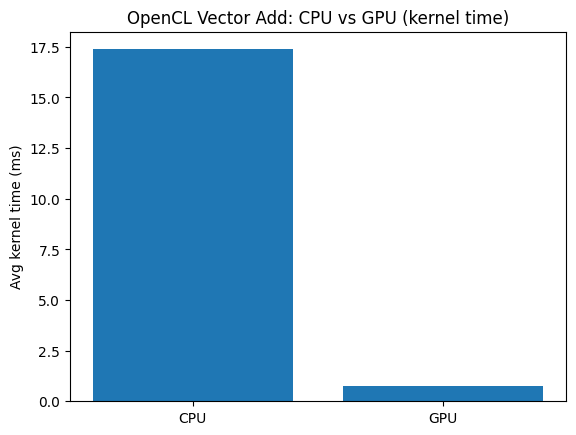

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("results_vecadd.csv")
display(df)

plt.figure()
plt.bar(df["device_type"], df["avg_kernel_ms"])
plt.ylabel("Avg kernel time (ms)")
plt.title("OpenCL Vector Add: CPU vs GPU (kernel time)")
plt.show()

In [1]:
!clinfo | egrep -i "Platform Name|Device Type|Device Name|OpenCL ICD" -n | head -n 200


2:  Platform Name                                   NVIDIA CUDA
34:  Platform Name                                   NVIDIA CUDA
36:  Device Name                                     Tesla T4
57:  Device Type                                     GPU
208:  clCreateContextFromType(NULL, CL_DEVICE_TYPE_CUSTOM)  Invalid device type for platform


# **Задача 2**

In [11]:
%%writefile kernel.cl
__kernel void matmul_naive(__global const float* A,
                           __global const float* B,
                           __global float* C,
                           const int N,
                           const int M,
                           const int K)
{
    // C is N x K
    const int row = get_global_id(0); // [0..N)
    const int col = get_global_id(1); // [0..K)

    if (row < N && col < K) {
        float sum = 0.0f;
        // A: N x M, B: M x K
        for (int i = 0; i < M; i++) {
            sum += A[row * M + i] * B[i * K + col];
        }
        C[row * K + col] = sum;
    }
}

Overwriting kernel.cl


In [12]:
%%writefile main_2.cpp
#include <CL/cl.h>

#include <algorithm>
#include <chrono>
#include <cmath>
#include <fstream>
#include <iomanip>
#include <iostream>
#include <random>
#include <string>
#include <vector>

#define CL_CHECK(err) do { \
    if ((err) != CL_SUCCESS) { \
        std::cerr << "OpenCL error " << (err) << " at " << __FILE__ << ":" << __LINE__ << std::endl; \
        std::exit(1); \
    } \
} while(0)

static std::string cl_device_type_str(cl_device_type t) {
    if (t & CL_DEVICE_TYPE_GPU) return "GPU";
    if (t & CL_DEVICE_TYPE_CPU) return "CPU";
    if (t & CL_DEVICE_TYPE_ACCELERATOR) return "ACCELERATOR";
    return "UNKNOWN";
}

static std::string get_device_name(cl_device_id dev) {
    size_t sz = 0;
    clGetDeviceInfo(dev, CL_DEVICE_NAME, 0, nullptr, &sz);
    std::string s(sz, '\0');
    clGetDeviceInfo(dev, CL_DEVICE_NAME, sz, s.data(), nullptr);
    while (!s.empty() && (s.back() == '\0' || s.back() == '\n' || s.back() == '\r')) s.pop_back();
    return s;
}

static std::string get_platform_name(cl_platform_id p) {
    size_t sz = 0;
    clGetPlatformInfo(p, CL_PLATFORM_NAME, 0, nullptr, &sz);
    std::string s(sz, '\0');
    clGetPlatformInfo(p, CL_PLATFORM_NAME, sz, s.data(), nullptr);
    while (!s.empty() && (s.back() == '\0' || s.back() == '\n' || s.back() == '\r')) s.pop_back();
    return s;
}

static std::string load_text_file(const std::string& path) {
    std::ifstream f(path);
    if (!f) throw std::runtime_error("Cannot open file: " + path);
    return std::string((std::istreambuf_iterator<char>(f)), std::istreambuf_iterator<char>());
}

static void matmul_cpu_ref(const std::vector<float>& A,
                           const std::vector<float>& B,
                           std::vector<float>& C,
                           int N, int M, int K)
{
    // C = A(NxM) * B(MxK)
    for (int r = 0; r < N; r++) {
        for (int c = 0; c < K; c++) {
            float sum = 0.0f;
            for (int i = 0; i < M; i++) {
                sum += A[r * M + i] * B[i * K + c];
            }
            C[r * K + c] = sum;
        }
    }
}

struct RunResult {
    bool ok = false;
    std::string device_type;
    std::string platform_name;
    std::string device_name;

    int N=0, M=0, K=0;
    int iters=0;
    size_t local0=0, local1=0;
    double avg_kernel_ms=0.0;
    double avg_total_ms=0.0;
    float max_abs_err=0.0f;
};

static RunResult run_on_device(cl_device_id device,
                               const std::vector<float>& A,
                               const std::vector<float>& B,
                               const std::vector<float>& Ref,
                               int N, int M, int K,
                               int iters,
                               size_t l0, size_t l1,
                               bool verbose=true)
{
    RunResult rr;
    rr.ok = false;
    rr.N=N; rr.M=M; rr.K=K; rr.iters=iters;
    rr.local0=l0; rr.local1=l1;

    cl_int err = CL_SUCCESS;

    cl_platform_id platform = nullptr;
    CL_CHECK(clGetDeviceInfo(device, CL_DEVICE_PLATFORM, sizeof(platform), &platform, nullptr));
    rr.platform_name = get_platform_name(platform);
    rr.device_name = get_device_name(device);

    cl_device_type dtype{};
    CL_CHECK(clGetDeviceInfo(device, CL_DEVICE_TYPE, sizeof(dtype), &dtype, nullptr));
    rr.device_type = cl_device_type_str(dtype);

    if (verbose) {
        std::cout << "\n=== " << rr.device_type << "(OpenCL) ===\n";
        std::cout << "Platform: " << rr.platform_name << "\n";
        std::cout << "Device:   " << rr.device_name << "\n";
        std::cout << "A: " << N << "x" << M << ", B: " << M << "x" << K << ", C: " << N << "x" << K << "\n";
        std::cout << "Local size: (" << l0 << ", " << l1 << ")\n";
        std::cout << "Iters: " << iters << "\n";
    }

    cl_context ctx = clCreateContext(nullptr, 1, &device, nullptr, nullptr, &err);
    CL_CHECK(err);

#if CL_TARGET_OPENCL_VERSION >= 200
    const cl_queue_properties props[] = { CL_QUEUE_PROPERTIES, CL_QUEUE_PROFILING_ENABLE, 0 };
    cl_command_queue q = clCreateCommandQueueWithProperties(ctx, device, props, &err);
#else
    cl_command_queue q = clCreateCommandQueue(ctx, device, CL_QUEUE_PROFILING_ENABLE, &err);
#endif
    CL_CHECK(err);

    std::string src = load_text_file("kernel.cl");
    const char* csrc = src.c_str();
    size_t srclen = src.size();
    cl_program prog = clCreateProgramWithSource(ctx, 1, &csrc, &srclen, &err);
    CL_CHECK(err);

    err = clBuildProgram(prog, 1, &device, "", nullptr, nullptr);
    if (err != CL_SUCCESS) {
        size_t log_sz = 0;
        clGetProgramBuildInfo(prog, device, CL_PROGRAM_BUILD_LOG, 0, nullptr, &log_sz);
        std::string log(log_sz, '\0');
        clGetProgramBuildInfo(prog, device, CL_PROGRAM_BUILD_LOG, log_sz, log.data(), nullptr);
        std::cerr << "Build failed:\n" << log << "\n";
        CL_CHECK(err);
    }

    cl_kernel kernel = clCreateKernel(prog, "matmul_naive", &err);
    CL_CHECK(err);

    const size_t bytesA = sizeof(float) * (size_t)N * (size_t)M;
    const size_t bytesB = sizeof(float) * (size_t)M * (size_t)K;
    const size_t bytesC = sizeof(float) * (size_t)N * (size_t)K;

    cl_mem dA = clCreateBuffer(ctx, CL_MEM_READ_ONLY,  bytesA, nullptr, &err); CL_CHECK(err);
    cl_mem dB = clCreateBuffer(ctx, CL_MEM_READ_ONLY,  bytesB, nullptr, &err); CL_CHECK(err);
    cl_mem dC = clCreateBuffer(ctx, CL_MEM_WRITE_ONLY, bytesC, nullptr, &err); CL_CHECK(err);

    CL_CHECK(clEnqueueWriteBuffer(q, dA, CL_TRUE, 0, bytesA, A.data(), 0, nullptr, nullptr));
    CL_CHECK(clEnqueueWriteBuffer(q, dB, CL_TRUE, 0, bytesB, B.data(), 0, nullptr, nullptr));

    CL_CHECK(clSetKernelArg(kernel, 0, sizeof(cl_mem), &dA));
    CL_CHECK(clSetKernelArg(kernel, 1, sizeof(cl_mem), &dB));
    CL_CHECK(clSetKernelArg(kernel, 2, sizeof(cl_mem), &dC));
    CL_CHECK(clSetKernelArg(kernel, 3, sizeof(int), &N));
    CL_CHECK(clSetKernelArg(kernel, 4, sizeof(int), &M));
    CL_CHECK(clSetKernelArg(kernel, 5, sizeof(int), &K));

    // global size must cover C: N x K
    size_t global[2] = { (size_t)N, (size_t)K };
    size_t local[2]  = { l0, l1 };

    // pad global to be multiple of local for nicer launch (optional)
    if (local[0] > 0) global[0] = ((global[0] + local[0] - 1) / local[0]) * local[0];
    if (local[1] > 0) global[1] = ((global[1] + local[1] - 1) / local[1]) * local[1];

    // warmup
    {
        cl_event ev{};
        CL_CHECK(clEnqueueNDRangeKernel(q, kernel, 2, nullptr, global, local, 0, nullptr, &ev));
        CL_CHECK(clWaitForEvents(1, &ev));
        clReleaseEvent(ev);
    }

    std::vector<float> C((size_t)N*(size_t)K);

    double sum_kernel_ms = 0.0;
    double sum_total_ms  = 0.0;

    for (int it = 0; it < iters; it++) {
        auto t0 = std::chrono::high_resolution_clock::now();

        cl_event kev{};
        CL_CHECK(clEnqueueNDRangeKernel(q, kernel, 2, nullptr, global, local, 0, nullptr, &kev));
        CL_CHECK(clWaitForEvents(1, &kev));

        cl_ulong t_start=0, t_end=0;
        CL_CHECK(clGetEventProfilingInfo(kev, CL_PROFILING_COMMAND_START, sizeof(t_start), &t_start, nullptr));
        CL_CHECK(clGetEventProfilingInfo(kev, CL_PROFILING_COMMAND_END,   sizeof(t_end),   &t_end,   nullptr));
        double kernel_ms = (t_end - t_start) * 1e-6;

        CL_CHECK(clEnqueueReadBuffer(q, dC, CL_TRUE, 0, bytesC, C.data(), 0, nullptr, nullptr));

        auto t1 = std::chrono::high_resolution_clock::now();
        double total_ms = std::chrono::duration<double, std::milli>(t1 - t0).count();

        sum_kernel_ms += kernel_ms;
        sum_total_ms  += total_ms;

        clReleaseEvent(kev);
    }

    rr.avg_kernel_ms = sum_kernel_ms / iters;
    rr.avg_total_ms  = sum_total_ms  / iters;

    // correctness
    float max_err = 0.0f;
    for (size_t i = 0; i < C.size(); i++) {
        max_err = std::max(max_err, std::fabs(C[i] - Ref[i]));
    }
    rr.max_abs_err = max_err;
    rr.ok = true;

    if (verbose) {
        std::cout << "Avg kernel time: " << std::fixed << std::setprecision(6) << rr.avg_kernel_ms << " ms\n";
        std::cout << "Avg total time (kernel+read): " << rr.avg_total_ms << " ms\n";
        std::cout << "Max abs error: " << rr.max_abs_err << "\n";
        std::cout << "Global size: (" << global[0] << ", " << global[1] << ")\n";
    }

    clReleaseMemObject(dA);
    clReleaseMemObject(dB);
    clReleaseMemObject(dC);
    clReleaseKernel(kernel);
    clReleaseProgram(prog);
    clReleaseCommandQueue(q);
    clReleaseContext(ctx);

    return rr;
}

static std::vector<cl_device_id> get_devices_by_type(cl_device_type want) {
    cl_uint nplat = 0;
    clGetPlatformIDs(0, nullptr, &nplat);
    std::vector<cl_platform_id> plats(nplat);
    clGetPlatformIDs(nplat, plats.data(), nullptr);

    std::vector<cl_device_id> out;
    for (auto p : plats) {
        cl_uint ndev = 0;
        cl_int err = clGetDeviceIDs(p, want, 0, nullptr, &ndev);
        if (err != CL_SUCCESS || ndev == 0) continue;
        std::vector<cl_device_id> devs(ndev);
        CL_CHECK(clGetDeviceIDs(p, want, ndev, devs.data(), nullptr));
        out.insert(out.end(), devs.begin(), devs.end());
    }
    return out;
}

int main(int argc, char** argv) {
    // defaults (можно менять)
    int N = 512, M = 512, K = 512;
    int iters = 10;
    size_t l0 = 16, l1 = 16; // local workgroup

    if (argc >= 4) { N = std::stoi(argv[1]); M = std::stoi(argv[2]); K = std::stoi(argv[3]); }
    if (argc >= 5) iters = std::stoi(argv[4]);

    std::cout << "OpenCL Matrix Multiplication (naive)\n";
    std::cout << "Usage: ./matmul [N M K] [iters]\n";

    // host matrices
    std::vector<float> A((size_t)N*(size_t)M);
    std::vector<float> B((size_t)M*(size_t)K);
    std::vector<float> Ref((size_t)N*(size_t)K);

    std::mt19937 rng(123);
    std::uniform_real_distribution<float> dist(-1.0f, 1.0f);
    for (auto& x : A) x = dist(rng);
    for (auto& x : B) x = dist(rng);

    std::cout << "\nComputing CPU reference (sequential)...\n";
    auto t0 = std::chrono::high_resolution_clock::now();
    matmul_cpu_ref(A, B, Ref, N, M, K);
    auto t1 = std::chrono::high_resolution_clock::now();
    double ref_ms = std::chrono::duration<double, std::milli>(t1 - t0).count();
    std::cout << "CPU ref time: " << std::fixed << std::setprecision(3) << ref_ms << " ms\n";

    // devices
    auto cpu_devs = get_devices_by_type(CL_DEVICE_TYPE_CPU);
    auto gpu_devs = get_devices_by_type(CL_DEVICE_TYPE_GPU);

    RunResult cpu_res, gpu_res;

    if (!cpu_devs.empty()) cpu_res = run_on_device(cpu_devs[0], A, B, Ref, N, M, K, iters, l0, l1);
    else std::cout << "\nCPU OpenCL device not found.\n";

    if (!gpu_devs.empty()) gpu_res = run_on_device(gpu_devs[0], A, B, Ref, N, M, K, iters, l0, l1);
    else std::cout << "\nGPU OpenCL device not found.\n";

    // save csv
    std::ofstream csv("results_matmul.csv");
    csv << "device_type,platform,device,N,M,K,iters,local0,local1,avg_kernel_ms,avg_total_ms,max_abs_err\n";
    if (cpu_res.ok) {
        csv << "CPU," << "\"" << cpu_res.platform_name << "\"" << ","
            << "\"" << cpu_res.device_name << "\"" << ","
            << cpu_res.N << "," << cpu_res.M << "," << cpu_res.K << ","
            << cpu_res.iters << ","
            << cpu_res.local0 << "," << cpu_res.local1 << ","
            << cpu_res.avg_kernel_ms << "," << cpu_res.avg_total_ms << ","
            << cpu_res.max_abs_err << "\n";
    }
    if (gpu_res.ok) {
        csv << "GPU," << "\"" << gpu_res.platform_name << "\"" << ","
            << "\"" << gpu_res.device_name << "\"" << ","
            << gpu_res.N << "," << gpu_res.M << "," << gpu_res.K << ","
            << gpu_res.iters << ","
            << gpu_res.local0 << "," << gpu_res.local1 << ","
            << gpu_res.avg_kernel_ms << "," << gpu_res.avg_total_ms << ","
            << gpu_res.max_abs_err << "\n";
    }
    csv.close();

    std::cout << "\nSaved results_matmul.csv\n";

    if (cpu_res.ok && gpu_res.ok) {
        double speedup = cpu_res.avg_kernel_ms / gpu_res.avg_kernel_ms;
        std::cout << "Speedup (CPU/GPU) by kernel time: " << std::fixed << std::setprecision(3)
                  << speedup << "x\n";
    }

    return 0;
}

Writing main_2.cpp


In [13]:
!g++ -O2 main_2.cpp -lOpenCL -o matmul
!./matmul 512 512 512 10
!cat results_matmul.csv

In file included from /usr/include/CL/cl.h:20,
                 from main_2.cpp:1:
/usr/include/CL/cl_version.h:22:104: note: ‘#pragma message: cl_version.h: CL_TARGET_OPENCL_VERSION is not defined. Defaulting to 300 (OpenCL 3.0)’
   22 | #pragma message("cl_version.h: CL_TARGET_OPENCL_VERSION is not defined. Defaulting to 300 (OpenCL 3.0)")
      |                                                                                                        ^
OpenCL Matrix Multiplication (naive)
Usage: ./matmul [N M K] [iters]

Computing CPU reference (sequential)...
CPU ref time: 188.688 ms

=== CPU(OpenCL) ===
Platform: Portable Computing Language
Device:   pthread-Intel(R) Xeon(R) CPU @ 2.00GHz
A: 512x512, B: 512x512, C: 512x512
Local size: (16, 16)
Iters: 10
Avg kernel time: 192.435711 ms
Avg total time (kernel+read): 192.784105 ms
Max abs error: 0.000010
Global size: (512, 512)

=== GPU(OpenCL) ===
Platform: NVIDIA CUDA
Device:   Tesla T4
A: 512x512, B: 512x512, C: 512x512
Local size: (1

,device_type,platform,device,N,M,K,iters,local0,local1,avg_kernel_ms,avg_total_ms,max_abs_err
0,CPU,Portable Computing Language,pthread-Intel(R) Xeon(R) CPU @ 2.00GHz,512,512,512,10,16,16,192.4360,192.78400,0.00001
1,GPU,NVIDIA CUDA,Tesla T4,512,512,512,10,16,16,6.2128,6.57584,0.00001


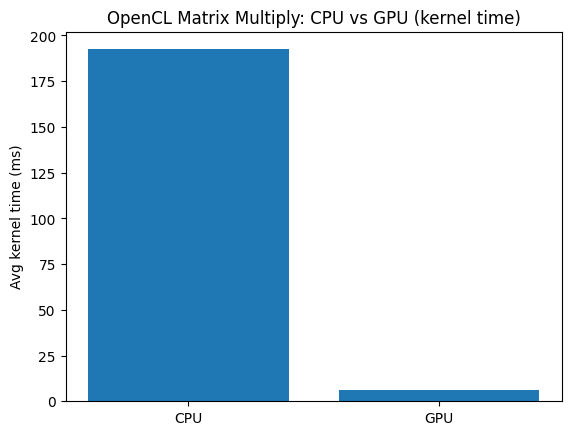

Speedup CPU/GPU (kernel): 30.974117950038632


In [14]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("results_matmul.csv")
display(df)

plt.figure()
plt.bar(df["device_type"], df["avg_kernel_ms"])
plt.ylabel("Avg kernel time (ms)")
plt.title("OpenCL Matrix Multiply: CPU vs GPU (kernel time)")
plt.show()

if set(df["device_type"]) == {"CPU","GPU"}:
    cpu = df[df.device_type=="CPU"].iloc[0]
    gpu = df[df.device_type=="GPU"].iloc[0]
    print("Speedup CPU/GPU (kernel):", cpu["avg_kernel_ms"]/gpu["avg_kernel_ms"])